0490.jpg a sunset on the beach


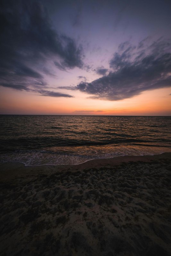

0032.jpg a sunset on the beach with a blur of the sky


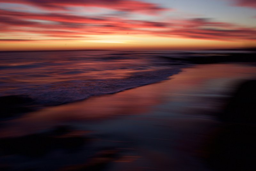

0116.jpg a sunset at the beach with a view of the city


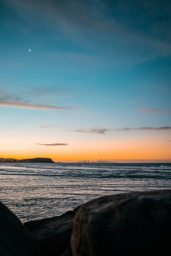

0149.jpg a man walking on the beach at sunset


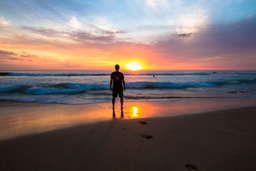

0285.jpg a beach with rocks and water at sunset


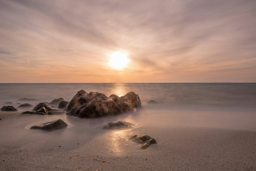

In [2]:
import requests
from PIL import Image
from IPython.display import display

query = "sunset on beach"
res = requests.get(f"http://127.0.0.1:8000/search?query={query}").json()

for r in res:
    print(r['filename'], r['caption'])
    img = Image.open(f"images/{r['filename']}")
    img.thumbnail((256,256))
    display(img)
